In [1]:
!pip install SimpleITK medmnist seaborn ncps scipy pillow Cmake nes-py

# Imports

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
import SimpleITK as ITK
import os
import imageio
import datetime
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
get_ipython().run_line_magic('matplotlib', 'inline')
from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras
from keras import backend as K
import keras.layers
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from tensorflow.keras.layers import LSTM, GRU
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from keras import optimizers
from keras.layers import Dropout
from keras.applications import mobilenet
from keras.applications import resnet50
from keras.applications import EfficientNetB4


import random as rn
rn.seed(30)
np.random.seed(30)
tf.random.set_seed

from ncps import wirings
from ncps.wirings import AutoNCP
from ncps.tf import LTC

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator


In [ ]:
#!unzip brats_train.zip

# Load train data

In [4]:
%cd drive/

/content/drive


In [5]:
%cd MyDrive/

/content/drive/MyDrive


In [6]:
%cd brats_train/

/content/drive/MyDrive/brats_train


# Plot accuracy

In [7]:
def plot(history):
    %config InlineBackend.figure_format = 'retina'
    plt.rcParams['figure.figsize'] = 8, 5
    plt.rcParams['font.size'] = 12
    plt.rcParams['savefig.format'] = 'pdf'
    sns.set(style='darkgrid', palette='deep')
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))

    axes[0].plot(history.history['loss'])
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['sparse_categorical_accuracy'])
    axes[1].plot(history.history['val_sparse_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_sparse_categorical_accuracy'])

    plt.tight_layout()

# Lets try previous model, without any transfer learning

In [ ]:
keras.backend.set_image_data_format('channels_last')

In [ ]:
class CNN_LTC():

    def init(self):
        self.image_height = 240
        self.image_width = 240
        self.channels = 1
        self.num_classes = 2
        self.frames_to_sample = 31
        self.batch_size = 8
        self.num_epochs = 200
        self.X_train = []
        self.y_train = []
        self.x_test = []
        self.y_test = []



    def create_data(self):
        # load train high
        print('train_high')
        dir_path = os.getcwd()
        dir_path += "/train/high"
        for pat in os.listdir(dir_path):
            filename = os.fsdecode(pat)
            for data in os.listdir(str(dir_path + '/'  + str(filename))):
                if "Flair" in data:
                    for file in os.listdir(str(dir_path) + '/'  + str(filename) + '/' + str(data)):
                        if 'mha' in file:
                            print(file)
                            img = list(ITK.GetArrayFromImage(ITK.ReadImage(str(dir_path) + '/'  + str(filename) + '/' + str(data) + '/' + file)))
                            self.X_train.append(np.array([x / float(255) for i, x in enumerate(img) if i % 5 == 0 and i > 30 and i < 110]))
                            self.y_train.append([1])
        # load train low
        print('train_low')
        dir_path = os.getcwd()
        dir_path += "/train/low"
        for pat in os.listdir(dir_path):
            filename = os.fsdecode(pat)
            for data in os.listdir(str(dir_path + '/'  + str(filename))):
                if "Flair" in data:
                    for file in os.listdir(str(dir_path) + '/'  + str(filename) + '/' + str(data)):
                        if 'mha' in file:
                            print(file)
                            img = list(ITK.GetArrayFromImage(ITK.ReadImage(str(dir_path) + '/'  + str(filename) + '/' + str(data) + '/' + file)))
                            self.X_train.append(np.array([x / float(255) for i, x in enumerate(img) if i % 5 == 0 and i > 30 and i < 110]))
                            self.y_train.append([0])
        # load test high
        print('test_high')
        dir_path = os.getcwd()
        dir_path += "/test/high"
        for pat in os.listdir(dir_path):
            filename = os.fsdecode(pat)
            for data in os.listdir(str(dir_path + '/'  + str(filename))):
                if "Flair" in data:
                    for file in os.listdir(str(dir_path) + '/'  + str(filename) + '/' + str(data)):
                        if 'mha' in file:
                            print(file)
                            img = list(ITK.GetArrayFromImage(ITK.ReadImage(str(dir_path) + '/'  + str(filename) + '/' + str(data) + '/' + file)))
                            self.x_test.append(np.array([x / float(255) for i, x in enumerate(img) if i % 5 == 0 and i > 30 and i < 110]))
                            self.y_test.append([1])
        # load test hlow
        print('test_low')
        dir_path = os.getcwd()
        dir_path += "/test/low"
        for pat in os.listdir(dir_path):
            filename = os.fsdecode(pat)
            for data in os.listdir(str(dir_path + '/'  + str(filename))):
                if "Flair" in data:
                    for file in os.listdir(str(dir_path) + '/'  + str(filename) + '/' + str(data)):
                        if 'mha' in file:
                            print(file)
                            img = list(ITK.GetArrayFromImage(ITK.ReadImage(str(dir_path) + '/'  + str(filename) + '/' + str(data) + '/' + file)))
                            self.x_test.append(np.array([x / float(255) for i, x in enumerate(img) if i % 5 == 0 and i > 30 and i < 110]))
                            self.y_test.append([0])
        print(len(self.X_train), len(self.y_train), len(self.x_test), len(self.y_test))
        # shuffle
        train = list(zip(self.X_train, self.y_train))
        rn.shuffle(train)
        self.X_train, self.y_train = zip(*train)
        self.X_train = np.array(self.X_train)
        self.y_train = np.array(self.y_train)

        test = list(zip(self.x_test, self.y_test))
        rn.shuffle(test)
        self.x_test, self.y_test = zip(*test)
        self.x_test = np.array(self.x_test)
        self.y_test = np.array(self.y_test)
        print(len(self.X_train), len(self.y_train), len(self.x_test), len(self.y_test))
        print(self.X_train[0].shape)
        return


    def train_model(self, model):

        #checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=20, min_lr=0.00000001)
        #earlystop = EarlyStopping(monitor="val_loss", min_delta=0,patience=50,verbose=1)
        self.callbacks_list = [LR]

        history=model.fit(self.X_train, self.y_train, batch_size = self.batch_size, epochs=self.num_epochs, verbose="auto",
                                callbacks=self.callbacks_list, validation_data = (self.x_test, self.y_test))
        return history


    def define_model(self, ncp_neurons=21,dense_neurons=32,dropout=0.25):

        self.wiring = AutoNCP(ncp_neurons,self.num_classes)

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(15,self.image_height,self.image_width, self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2)), ))

        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(Dropout(dropout))


        model.add(TimeDistributed(Flatten()))
        model.add(Dense(dense_neurons, activation='relu'))

        model.add(Dropout(dropout))
        model.add(LTC(self.wiring, return_sequences=False))
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes, activation='softmax'))

        optimiser = optimizers.Adam(learning_rate=0.01)
        model.compile(optimizer=optimiser, loss=keras.losses.SparseCategoricalCrossentropy(), metrics=[keras.metrics.SparseCategoricalAccuracy()])
        return model

In [ ]:
cnn_ltc = CNN_LTC()
cnn_ltc.init()
cnn_ltc.create_data()
cnn_ltc_model = cnn_ltc.define_model(ncp_neurons=30,dense_neurons=32,dropout=0.1)
cnn_ltc_model.summary()

train_high
VSD.Brain.XX.O.MR_Flair.35533.mha
VSD.Brain.XX.O.MR_Flair.40827.mha
VSD.Brain.XX.O.MR_Flair.35537.mha
VSD.Brain.XX.O.MR_Flair.35541.mha
VSD.Brain.XX.O.MR_Flair.35545.mha
VSD.Brain.XX.O.MR_Flair.35549.mha
VSD.Brain.XX.O.MR_Flair.35553.mha
VSD.Brain.XX.O.MR_Flair.35557.mha
VSD.Brain.XX.O.MR_Flair.35561.mha
VSD.Brain.XX.O.MR_Flair.35565.mha
VSD.Brain.XX.O.MR_Flair.35573.mha
VSD.Brain.XX.O.MR_Flair.35577.mha
VSD.Brain.XX.O.MR_Flair.35591.mha
VSD.Brain.XX.O.MR_Flair.35595.mha
VSD.Brain.XX.O.MR_Flair.35599.mha
VSD.Brain.XX.O.MR_Flair.35603.mha
VSD.Brain.XX.O.MR_Flair.40859.mha
VSD.Brain.XX.O.MR_Flair.35607.mha
VSD.Brain.XX.O.MR_Flair.40863.mha
VSD.Brain.XX.O.MR_Flair.35611.mha
VSD.Brain.XX.O.MR_Flair.35615.mha
VSD.Brain.XX.O.MR_Flair.40871.mha
VSD.Brain.XX.O.MR_Flair.35619.mha
VSD.Brain.XX.O.MR_Flair.35623.mha
train_low
VSD.Brain.XX.O.MR_Flair.35529.mha
VSD.Brain.XX.O.MR_Flair.40819.mha
VSD.Brain.XX.O.MR_Flair.40823.mha
VSD.Brain.XX.O.MR_Flair.40831.mha
VSD.Brain.XX.O.MR_Flair.355

In [ ]:
with tf.device('/device:GPU:0'):
    model = cnn_ltc.train_model(cnn_ltc_model)

Epoch 1/200
6/6 [==============================] - 11s 388ms/step - loss: 0.7431 - sparse_categorical_accuracy: 0.4792 - val_loss: 0.6882 - val_sparse_categorical_accuracy: 0.5000 - lr: 0.0100
Epoch 2/200
6/6 [==============================] - 1s 222ms/step - loss: 0.6877 - sparse_categorical_accuracy: 0.5833 - val_loss: 0.7174 - val_sparse_categorical_accuracy: 0.5000 - lr: 0.0100
Epoch 3/200
6/6 [==============================] - 1s 225ms/step - loss: 0.7127 - sparse_categorical_accuracy: 0.5000 - val_loss: 0.7224 - val_sparse_categorical_accuracy: 0.5000 - lr: 0.0100
Epoch 4/200
6/6 [==============================] - 1s 220ms/step - loss: 0.7078 - sparse_categorical_accuracy: 0.3542 - val_loss: 0.7186 - val_sparse_categorical_accuracy: 0.5000 - lr: 0.0100
Epoch 5/200
6/6 [==============================] - 1s 201ms/step - loss: 0.6982 - sparse_categorical_accuracy: 0.4167 - val_loss: 0.7113 - val_sparse_categorical_accuracy: 0.5000 - lr: 0.0100
Epoch 6/200
6/6 [======================

In [ ]:
plot(model)

# Trying transfer learning with mobilenet

In [26]:
keras.backend.set_image_data_format('channels_first')
class CNN_LTC():

    def init(self):
        self.image_height = 240
        self.image_width = 240
        self.channels = 3
        self.num_classes = 2
        self.frames_to_sample = 31
        self.batch_size = 1
        self.num_epochs = 100
        self.X_train = []
        self.y_train = []
        self.x_test = []
        self.y_test = []
        self.mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False, input_shape=(3, 240, 240))



    def create_data(self):
        # load train high
        print('train_high')
        dir_path = os.getcwd()
        dir_path += "/train/high"
        for pat in os.listdir(dir_path):
            filename = os.fsdecode(pat)
            for data in os.listdir(str(dir_path + '/'  + str(filename))):
                if "Flair" in data:
                    for file in os.listdir(str(dir_path) + '/'  + str(filename) + '/' + str(data)):
                        if 'mha' in file:
                            print(file)
                            img = list(ITK.GetArrayFromImage(ITK.ReadImage(str(dir_path) + '/'  + str(filename) + '/' + str(data) + '/' + file)))
                            self.X_train.append(np.array([np.array([np.zeros((240, 240)), x / float(255), np.zeros((240, 240))]) for i, x in enumerate(img) if i % 5 == 0 and i > 30 and i < 110]))
                            self.y_train.append([1])
        # load train low
        print('train_low')
        dir_path = os.getcwd()
        dir_path += "/train/low"
        for pat in os.listdir(dir_path):
            filename = os.fsdecode(pat)
            for data in os.listdir(str(dir_path + '/'  + str(filename))):
                if "Flair" in data:
                    for file in os.listdir(str(dir_path) + '/'  + str(filename) + '/' + str(data)):
                        if 'mha' in file:
                            print(file)
                            img = list(ITK.GetArrayFromImage(ITK.ReadImage(str(dir_path) + '/'  + str(filename) + '/' + str(data) + '/' + file)))
                            self.X_train.append(np.array([np.array([np.zeros((240, 240)), x / float(255), np.zeros((240, 240))]) for i, x in enumerate(img) if i % 5 == 0 and i > 30 and i < 110]))
                            self.y_train.append([0])
        # load test high
        print('test_high')
        dir_path = os.getcwd()
        dir_path += "/test/high"
        for pat in os.listdir(dir_path):
            filename = os.fsdecode(pat)
            for data in os.listdir(str(dir_path + '/'  + str(filename))):
                if "Flair" in data:
                    for file in os.listdir(str(dir_path) + '/'  + str(filename) + '/' + str(data)):
                        if 'mha' in file:
                            print(file)
                            img = list(ITK.GetArrayFromImage(ITK.ReadImage(str(dir_path) + '/'  + str(filename) + '/' + str(data) + '/' + file)))
                            self.x_test.append(np.array([np.array([np.zeros((240, 240)), x / float(255), np.zeros((240, 240))]) for i, x in enumerate(img) if i % 5 == 0 and i > 30 and i < 110]))
                            self.y_test.append([1])
        # load test hlow
        print('test_low')
        dir_path = os.getcwd()
        dir_path += "/test/low"
        for pat in os.listdir(dir_path):
            filename = os.fsdecode(pat)
            for data in os.listdir(str(dir_path + '/'  + str(filename))):
                if "Flair" in data:
                    for file in os.listdir(str(dir_path) + '/'  + str(filename) + '/' + str(data)):
                        if 'mha' in file:
                            print(file)
                            img = list(ITK.GetArrayFromImage(ITK.ReadImage(str(dir_path) + '/'  + str(filename) + '/' + str(data) + '/' + file)))
                            self.x_test.append(np.array([np.array([np.zeros((240, 240)), x / float(255), np.zeros((240, 240))]) for i, x in enumerate(img) if i % 5 == 0 and i > 30 and i < 110]))
                            self.y_test.append([0])
        print(len(self.X_train), len(self.y_train), len(self.x_test), len(self.y_test))
        # shuffle
        train = list(zip(self.X_train, self.y_train))
        rn.shuffle(train)
        self.X_train, self.y_train = zip(*train)
        self.X_train = np.array(self.X_train)
        self.y_train = np.array(self.y_train)

        test = list(zip(self.x_test, self.y_test))
        rn.shuffle(test)
        self.x_test, self.y_test = zip(*test)
        self.x_test = np.array(self.x_test)
        self.y_test = np.array(self.y_test)
        print(len(self.X_train), len(self.y_train), len(self.x_test), len(self.y_test))
        print(self.X_train[0].shape)
        return


    def train_model(self, model):

        #checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=5, min_lr=0.000001)
        #earlystop = EarlyStopping(monitor="val_loss", min_delta=0,patience=50,verbose=1)
        self.callbacks_list = [LR]

        history=model.fit(self.X_train, self.y_train, batch_size = self.batch_size, epochs=self.num_epochs, verbose="auto",
                                callbacks=self.callbacks_list, validation_data = (self.x_test, self.y_test))
        return history


    def define_model(self, ncp_neurons=21,dense_neurons=32,dropout=0.25):

        self.wiring = AutoNCP(ncp_neurons,self.num_classes)

        model = Sequential()

        model.add(TimeDistributed(self.mobilenet_transfer,input_shape=(15,self.channels,240,240)))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))



        model.add(TimeDistributed(Flatten()))


        model.add(LTC(self.wiring, return_sequences=False))


        model.add(Dense(self.num_classes, activation='softmax'))

        optimiser = optimizers.Adam(learning_rate=0.01)
        model.compile(optimizer=optimiser, loss=keras.losses.SparseCategoricalCrossentropy(), metrics=[keras.metrics.SparseCategoricalAccuracy()])
        return model

In [27]:
cnn_ltc = CNN_LTC()
cnn_ltc.init()
cnn_ltc.create_data()
cnn_ltc_model = cnn_ltc.define_model(ncp_neurons=100,dense_neurons=32,dropout=0.1)
cnn_ltc_model.summary()

train_high
VSD.Brain.XX.O.MR_Flair.35533.mha
VSD.Brain.XX.O.MR_Flair.40827.mha
VSD.Brain.XX.O.MR_Flair.35537.mha
VSD.Brain.XX.O.MR_Flair.35541.mha
VSD.Brain.XX.O.MR_Flair.35545.mha
VSD.Brain.XX.O.MR_Flair.35549.mha
VSD.Brain.XX.O.MR_Flair.35553.mha
VSD.Brain.XX.O.MR_Flair.35557.mha
VSD.Brain.XX.O.MR_Flair.35561.mha
VSD.Brain.XX.O.MR_Flair.35565.mha
VSD.Brain.XX.O.MR_Flair.35573.mha
VSD.Brain.XX.O.MR_Flair.35577.mha
VSD.Brain.XX.O.MR_Flair.35591.mha
VSD.Brain.XX.O.MR_Flair.35595.mha
VSD.Brain.XX.O.MR_Flair.35599.mha
VSD.Brain.XX.O.MR_Flair.35603.mha
VSD.Brain.XX.O.MR_Flair.40859.mha
VSD.Brain.XX.O.MR_Flair.35607.mha
VSD.Brain.XX.O.MR_Flair.40863.mha
VSD.Brain.XX.O.MR_Flair.35611.mha
VSD.Brain.XX.O.MR_Flair.35615.mha
VSD.Brain.XX.O.MR_Flair.40871.mha
VSD.Brain.XX.O.MR_Flair.35619.mha
VSD.Brain.XX.O.MR_Flair.35623.mha
train_low
VSD.Brain.XX.O.MR_Flair.35529.mha
VSD.Brain.XX.O.MR_Flair.40819.mha
VSD.Brain.XX.O.MR_Flair.40823.mha
VSD.Brain.XX.O.MR_Flair.40831.mha
VSD.Brain.XX.O.MR_Flair.355

In [28]:
with tf.device('/device:GPU:0'):
    model = cnn_ltc.train_model(cnn_ltc_model)

Epoch 1/100
48/48 [==============================] - 27s 151ms/step - loss: 0.7707 - sparse_categorical_accuracy: 0.5417 - val_loss: 0.6964 - val_sparse_categorical_accuracy: 0.5000 - lr: 0.0100
Epoch 2/100
48/48 [==============================] - 6s 134ms/step - loss: 0.7139 - sparse_categorical_accuracy: 0.5000 - val_loss: 0.6938 - val_sparse_categorical_accuracy: 0.5000 - lr: 0.0100
Epoch 3/100
48/48 [==============================] - 6s 119ms/step - loss: 0.7040 - sparse_categorical_accuracy: 0.4583 - val_loss: 0.6936 - val_sparse_categorical_accuracy: 0.5000 - lr: 0.0100
Epoch 4/100
48/48 [==============================] - 6s 135ms/step - loss: 0.7084 - sparse_categorical_accuracy: 0.5000 - val_loss: 0.6934 - val_sparse_categorical_accuracy: 0.5000 - lr: 0.0100
Epoch 5/100
48/48 [==============================] - 6s 120ms/step - loss: 0.7003 - sparse_categorical_accuracy: 0.5000 - val_loss: 0.6949 - val_sparse_categorical_accuracy: 0.5000 - lr: 0.0100
Epoch 6/100
48/48 [==========

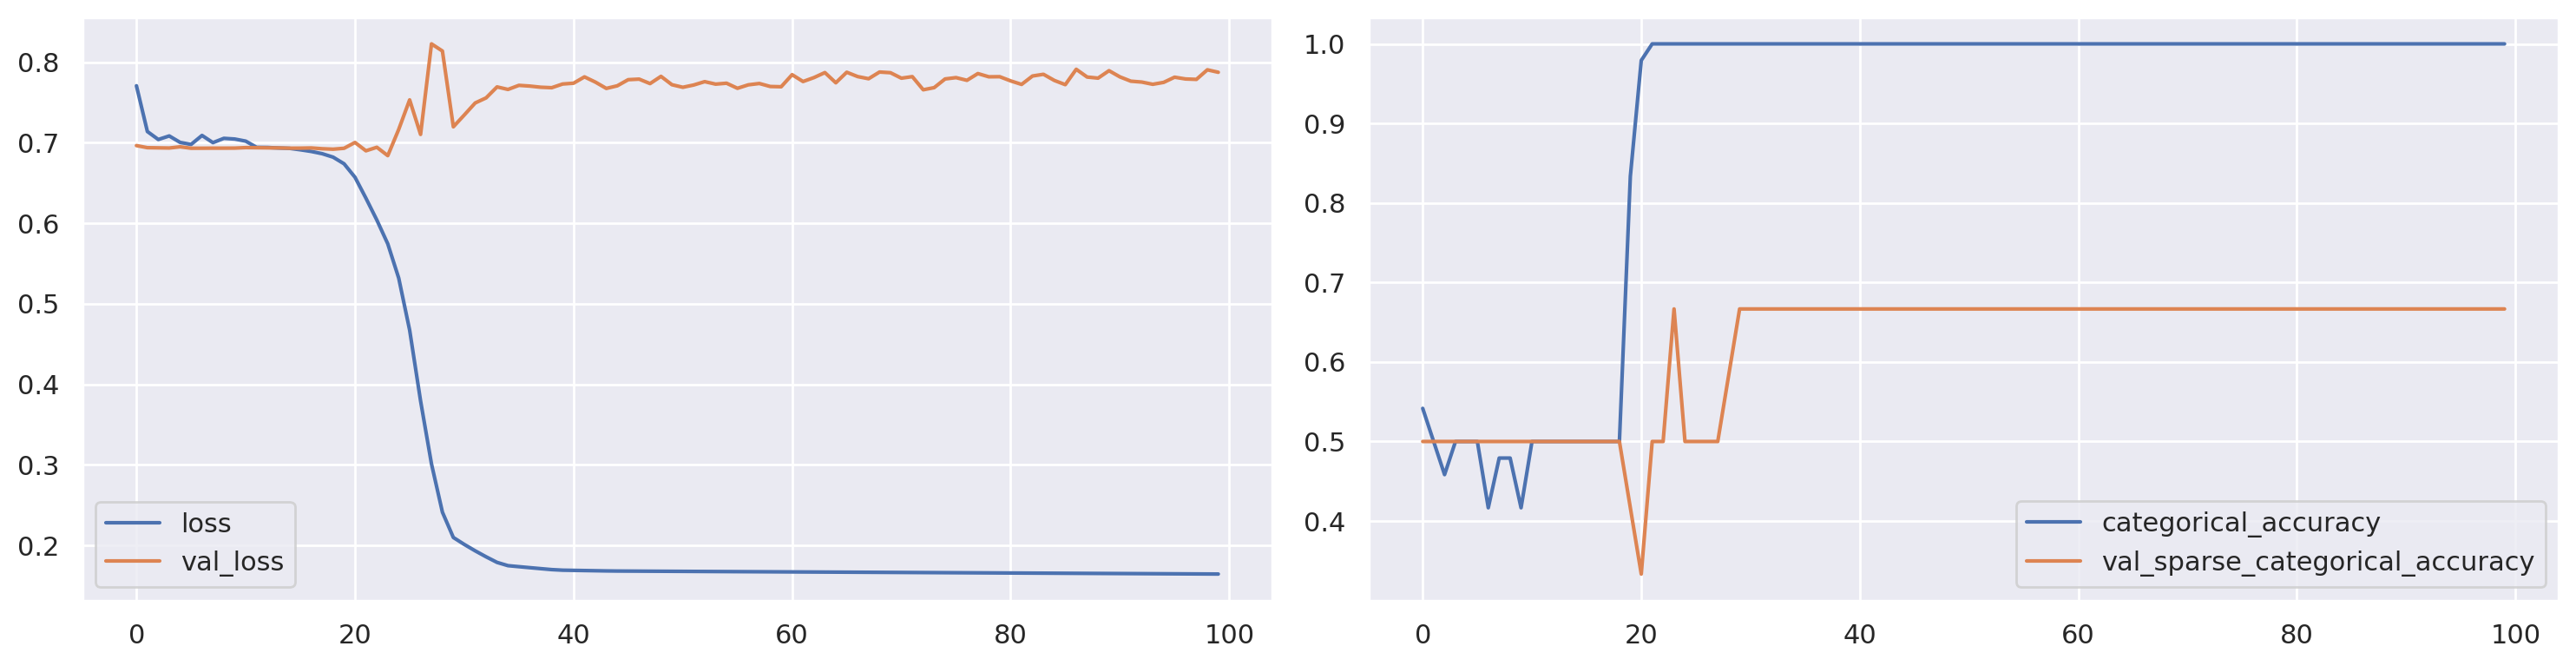

In [29]:
plot(model)

# Ghange mobilenet to resnet

In [7]:
keras.backend.set_image_data_format('channels_first')
class CNN_LTC():

    def init(self):
        self.image_height = 240
        self.image_width = 240
        self.channels = 3
        self.num_classes = 2
        self.frames_to_sample = 31
        self.batch_size = 1
        self.num_epochs = 100
        self.X_train = []
        self.y_train = []
        self.x_test = []
        self.y_test = []
        self.resnet_transfer = resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(3, 240, 240))



    def create_data(self):
        # load train high
        print('train_high')
        dir_path = os.getcwd()
        dir_path += "/train/high"
        for pat in os.listdir(dir_path):
            filename = os.fsdecode(pat)
            for data in os.listdir(str(dir_path + '/'  + str(filename))):
                if "Flair" in data:
                    for file in os.listdir(str(dir_path) + '/'  + str(filename) + '/' + str(data)):
                        if 'mha' in file:
                            print(file)
                            img = list(ITK.GetArrayFromImage(ITK.ReadImage(str(dir_path) + '/'  + str(filename) + '/' + str(data) + '/' + file)))
                            self.X_train.append(np.array([np.array([np.zeros((240, 240)), x / float(255), np.zeros((240, 240))]) for i, x in enumerate(img) if i % 5 == 0 and i > 30 and i < 110]))
                            self.y_train.append([1])
        # load train low
        print('train_low')
        dir_path = os.getcwd()
        dir_path += "/train/low"
        for pat in os.listdir(dir_path):
            filename = os.fsdecode(pat)
            for data in os.listdir(str(dir_path + '/'  + str(filename))):
                if "Flair" in data:
                    for file in os.listdir(str(dir_path) + '/'  + str(filename) + '/' + str(data)):
                        if 'mha' in file:
                            print(file)
                            img = list(ITK.GetArrayFromImage(ITK.ReadImage(str(dir_path) + '/'  + str(filename) + '/' + str(data) + '/' + file)))
                            self.X_train.append(np.array([np.array([np.zeros((240, 240)), x / float(255), np.zeros((240, 240))]) for i, x in enumerate(img) if i % 5 == 0 and i > 30 and i < 110]))
                            self.y_train.append([0])
        # load test high
        print('test_high')
        dir_path = os.getcwd()
        dir_path += "/test/high"
        for pat in os.listdir(dir_path):
            filename = os.fsdecode(pat)
            for data in os.listdir(str(dir_path + '/'  + str(filename))):
                if "Flair" in data:
                    for file in os.listdir(str(dir_path) + '/'  + str(filename) + '/' + str(data)):
                        if 'mha' in file:
                            print(file)
                            img = list(ITK.GetArrayFromImage(ITK.ReadImage(str(dir_path) + '/'  + str(filename) + '/' + str(data) + '/' + file)))
                            self.x_test.append(np.array([np.array([np.zeros((240, 240)), x / float(255), np.zeros((240, 240))]) for i, x in enumerate(img) if i % 5 == 0 and i > 30 and i < 110]))
                            self.y_test.append([1])
        # load test hlow
        print('test_low')
        dir_path = os.getcwd()
        dir_path += "/test/low"
        for pat in os.listdir(dir_path):
            filename = os.fsdecode(pat)
            for data in os.listdir(str(dir_path + '/'  + str(filename))):
                if "Flair" in data:
                    for file in os.listdir(str(dir_path) + '/'  + str(filename) + '/' + str(data)):
                        if 'mha' in file:
                            print(file)
                            img = list(ITK.GetArrayFromImage(ITK.ReadImage(str(dir_path) + '/'  + str(filename) + '/' + str(data) + '/' + file)))
                            self.x_test.append(np.array([np.array([np.zeros((240, 240)), x / float(255), np.zeros((240, 240))]) for i, x in enumerate(img) if i % 5 == 0 and i > 30 and i < 110]))
                            self.y_test.append([0])
        print(len(self.X_train), len(self.y_train), len(self.x_test), len(self.y_test))
        # shuffle
        train = list(zip(self.X_train, self.y_train))
        rn.shuffle(train)
        self.X_train, self.y_train = zip(*train)
        self.X_train = np.array(self.X_train)
        self.y_train = np.array(self.y_train)

        test = list(zip(self.x_test, self.y_test))
        rn.shuffle(test)
        self.x_test, self.y_test = zip(*test)
        self.x_test = np.array(self.x_test)
        self.y_test = np.array(self.y_test)
        print(len(self.X_train), len(self.y_train), len(self.x_test), len(self.y_test))
        print(self.X_train[0].shape)
        return


    def train_model(self, model):

        #checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=5, min_lr=0.000001)
        #earlystop = EarlyStopping(monitor="val_loss", min_delta=0,patience=50,verbose=1)
        self.callbacks_list = [LR]

        history=model.fit(self.X_train, self.y_train, batch_size = self.batch_size, epochs=self.num_epochs, verbose="auto",
                                callbacks=self.callbacks_list, validation_data = (self.x_test, self.y_test))
        return history


    def define_model(self, ncp_neurons=21,dense_neurons=32,dropout=0.05):

        self.wiring = AutoNCP(ncp_neurons,self.num_classes)

        model = Sequential()

        model.add(TimeDistributed(self.resnet_transfer,input_shape=(15,self.channels,240,240)))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(Dropout(dropout))


        model.add(TimeDistributed(Flatten()))

        model.add(Dropout(dropout))
        model.add(LTC(self.wiring, return_sequences=False))
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes, activation='softmax'))

        optimiser = optimizers.AdamW(learning_rate=0.0001, weight_decay=0.0001)
        model.compile(optimizer=optimiser, loss=keras.losses.SparseCategoricalCrossentropy(), metrics=[keras.metrics.SparseCategoricalAccuracy()])
        return model

In [10]:
cnn_ltc = CNN_LTC()
cnn_ltc.init()
cnn_ltc.create_data()
cnn_ltc_model = cnn_ltc.define_model(ncp_neurons=16,dense_neurons=32,dropout=0.1)
cnn_ltc_model.summary()

train_high
VSD.Brain.XX.O.MR_Flair.35533.mha
VSD.Brain.XX.O.MR_Flair.40827.mha
VSD.Brain.XX.O.MR_Flair.35537.mha
VSD.Brain.XX.O.MR_Flair.35541.mha
VSD.Brain.XX.O.MR_Flair.35545.mha
VSD.Brain.XX.O.MR_Flair.35549.mha
VSD.Brain.XX.O.MR_Flair.35553.mha
VSD.Brain.XX.O.MR_Flair.35557.mha
VSD.Brain.XX.O.MR_Flair.35561.mha
VSD.Brain.XX.O.MR_Flair.35565.mha
VSD.Brain.XX.O.MR_Flair.35573.mha
VSD.Brain.XX.O.MR_Flair.35577.mha
VSD.Brain.XX.O.MR_Flair.35591.mha
VSD.Brain.XX.O.MR_Flair.35595.mha
VSD.Brain.XX.O.MR_Flair.35599.mha
VSD.Brain.XX.O.MR_Flair.35603.mha
VSD.Brain.XX.O.MR_Flair.40859.mha
VSD.Brain.XX.O.MR_Flair.35607.mha
VSD.Brain.XX.O.MR_Flair.40863.mha
VSD.Brain.XX.O.MR_Flair.35611.mha
VSD.Brain.XX.O.MR_Flair.35615.mha
VSD.Brain.XX.O.MR_Flair.40871.mha
VSD.Brain.XX.O.MR_Flair.35619.mha
VSD.Brain.XX.O.MR_Flair.35623.mha
train_low
VSD.Brain.XX.O.MR_Flair.35529.mha
VSD.Brain.XX.O.MR_Flair.40819.mha
VSD.Brain.XX.O.MR_Flair.40823.mha
VSD.Brain.XX.O.MR_Flair.40831.mha
VSD.Brain.XX.O.MR_Flair.355

In [11]:
with tf.device('/device:GPU:0'):
    model = cnn_ltc.train_model(cnn_ltc_model)

Epoch 1/100
48/48 [==============================] - 58s 363ms/step - loss: 0.7534 - sparse_categorical_accuracy: 0.5000 - val_loss: 0.7407 - val_sparse_categorical_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 2/100
48/48 [==============================] - 15s 305ms/step - loss: 0.7392 - sparse_categorical_accuracy: 0.4792 - val_loss: 0.7358 - val_sparse_categorical_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 3/100
48/48 [==============================] - 15s 303ms/step - loss: 0.7166 - sparse_categorical_accuracy: 0.4792 - val_loss: 0.7304 - val_sparse_categorical_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 4/100
48/48 [==============================] - 14s 301ms/step - loss: 0.6814 - sparse_categorical_accuracy: 0.4792 - val_loss: 0.7209 - val_sparse_categorical_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 5/100
48/48 [==============================] - 15s 309ms/step - loss: 0.6866 - sparse_categorical_accuracy: 0.4583 - val_loss: 0.7124 - val_sparse_categorical_accuracy: 0.5000 - lr: 1.0000e-04
Epoch

KeyboardInterrupt: 

# Lets try changing some hyperparams

In [16]:
keras.backend.set_image_data_format('channels_first')
class CNN_LTC():

    def init(self):
        self.image_height = 240
        self.image_width = 240
        self.channels = 3
        self.num_classes = 2
        self.frames_to_sample = 31
        self.batch_size = 1
        self.num_epochs = 100
        self.X_train = []
        self.y_train = []
        self.x_test = []
        self.y_test = []
        self.resnet_transfer = resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(3, 240, 240))



    def create_data(self):
        # load train high
        print('train_high')
        dir_path = os.getcwd()
        dir_path += "/train/high"
        for pat in os.listdir(dir_path):
            filename = os.fsdecode(pat)
            for data in os.listdir(str(dir_path + '/'  + str(filename))):
                if "Flair" in data:
                    for file in os.listdir(str(dir_path) + '/'  + str(filename) + '/' + str(data)):
                        if 'mha' in file:
                            print(file)
                            img = list(ITK.GetArrayFromImage(ITK.ReadImage(str(dir_path) + '/'  + str(filename) + '/' + str(data) + '/' + file)))
                            self.X_train.append(np.array([np.array([np.zeros((240, 240)), x / float(255), np.zeros((240, 240))]) for i, x in enumerate(img) if i % 5 == 0 and i > 30 and i < 110]))
                            self.y_train.append([1])
        # load train low
        print('train_low')
        dir_path = os.getcwd()
        dir_path += "/train/low"
        for pat in os.listdir(dir_path):
            filename = os.fsdecode(pat)
            for data in os.listdir(str(dir_path + '/'  + str(filename))):
                if "Flair" in data:
                    for file in os.listdir(str(dir_path) + '/'  + str(filename) + '/' + str(data)):
                        if 'mha' in file:
                            print(file)
                            img = list(ITK.GetArrayFromImage(ITK.ReadImage(str(dir_path) + '/'  + str(filename) + '/' + str(data) + '/' + file)))
                            self.X_train.append(np.array([np.array([np.zeros((240, 240)), x / float(255), np.zeros((240, 240))]) for i, x in enumerate(img) if i % 5 == 0 and i > 30 and i < 110]))
                            self.y_train.append([0])
        # load test high
        print('test_high')
        dir_path = os.getcwd()
        dir_path += "/test/high"
        for pat in os.listdir(dir_path):
            filename = os.fsdecode(pat)
            for data in os.listdir(str(dir_path + '/'  + str(filename))):
                if "Flair" in data:
                    for file in os.listdir(str(dir_path) + '/'  + str(filename) + '/' + str(data)):
                        if 'mha' in file:
                            print(file)
                            img = list(ITK.GetArrayFromImage(ITK.ReadImage(str(dir_path) + '/'  + str(filename) + '/' + str(data) + '/' + file)))
                            self.x_test.append(np.array([np.array([np.zeros((240, 240)), x / float(255), np.zeros((240, 240))]) for i, x in enumerate(img) if i % 5 == 0 and i > 30 and i < 110]))
                            self.y_test.append([1])
        # load test hlow
        print('test_low')
        dir_path = os.getcwd()
        dir_path += "/test/low"
        for pat in os.listdir(dir_path):
            filename = os.fsdecode(pat)
            for data in os.listdir(str(dir_path + '/'  + str(filename))):
                if "Flair" in data:
                    for file in os.listdir(str(dir_path) + '/'  + str(filename) + '/' + str(data)):
                        if 'mha' in file:
                            print(file)
                            img = list(ITK.GetArrayFromImage(ITK.ReadImage(str(dir_path) + '/'  + str(filename) + '/' + str(data) + '/' + file)))
                            self.x_test.append(np.array([np.array([np.zeros((240, 240)), x / float(255), np.zeros((240, 240))]) for i, x in enumerate(img) if i % 5 == 0 and i > 30 and i < 110]))
                            self.y_test.append([0])
        print(len(self.X_train), len(self.y_train), len(self.x_test), len(self.y_test))
        # shuffle
        train = list(zip(self.X_train, self.y_train))
        rn.shuffle(train)
        self.X_train, self.y_train = zip(*train)
        self.X_train = np.array(self.X_train)
        self.y_train = np.array(self.y_train)

        test = list(zip(self.x_test, self.y_test))
        rn.shuffle(test)
        self.x_test, self.y_test = zip(*test)
        self.x_test = np.array(self.x_test)
        self.y_test = np.array(self.y_test)
        print(len(self.X_train), len(self.y_train), len(self.x_test), len(self.y_test))
        print(self.X_train[0].shape)
        return


    def train_model(self, model):

        #checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=5, min_lr=0.000001)
        #earlystop = EarlyStopping(monitor="val_loss", min_delta=0,patience=50,verbose=1)
        self.callbacks_list = [LR]

        history=model.fit(self.X_train, self.y_train, batch_size = self.batch_size, epochs=self.num_epochs, verbose="auto",
                                callbacks=self.callbacks_list, validation_data = (self.x_test, self.y_test))
        return history


    def define_model(self, ncp_neurons=21,dense_neurons=32,dropout=0.15):

        self.wiring = AutoNCP(ncp_neurons,self.num_classes)

        model = Sequential()

        model.add(TimeDistributed(self.resnet_transfer,input_shape=(15,self.channels,240,240)))
        for layer in model.layers: layer.trainable = False
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(Dropout(dropout))


        model.add(TimeDistributed(Flatten()))

        model.add(Dropout(dropout))
        model.add(LTC(self.wiring, return_sequences=False))
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes, activation='softmax'))

        optimiser = optimizers.AdamW(learning_rate=0.01, weight_decay=0.0001)
        model.compile(optimizer=optimiser, loss=keras.losses.SparseCategoricalCrossentropy(), metrics=[keras.metrics.SparseCategoricalAccuracy()])
        return model

In [17]:
cnn_ltc = CNN_LTC()
cnn_ltc.init()
cnn_ltc.create_data()
cnn_ltc_model = cnn_ltc.define_model(ncp_neurons=16,dense_neurons=32,dropout=0.05)
cnn_ltc_model.summary()

train_high
VSD.Brain.XX.O.MR_Flair.35533.mha
VSD.Brain.XX.O.MR_Flair.40827.mha
VSD.Brain.XX.O.MR_Flair.35537.mha
VSD.Brain.XX.O.MR_Flair.35541.mha
VSD.Brain.XX.O.MR_Flair.35545.mha
VSD.Brain.XX.O.MR_Flair.35549.mha
VSD.Brain.XX.O.MR_Flair.35553.mha
VSD.Brain.XX.O.MR_Flair.35557.mha
VSD.Brain.XX.O.MR_Flair.35561.mha
VSD.Brain.XX.O.MR_Flair.35565.mha
VSD.Brain.XX.O.MR_Flair.35573.mha
VSD.Brain.XX.O.MR_Flair.35577.mha
VSD.Brain.XX.O.MR_Flair.35591.mha
VSD.Brain.XX.O.MR_Flair.35595.mha
VSD.Brain.XX.O.MR_Flair.35599.mha
VSD.Brain.XX.O.MR_Flair.35603.mha
VSD.Brain.XX.O.MR_Flair.40859.mha
VSD.Brain.XX.O.MR_Flair.35607.mha
VSD.Brain.XX.O.MR_Flair.40863.mha
VSD.Brain.XX.O.MR_Flair.35611.mha
VSD.Brain.XX.O.MR_Flair.35615.mha
VSD.Brain.XX.O.MR_Flair.40871.mha
VSD.Brain.XX.O.MR_Flair.35619.mha
VSD.Brain.XX.O.MR_Flair.35623.mha
train_low
VSD.Brain.XX.O.MR_Flair.35529.mha
VSD.Brain.XX.O.MR_Flair.40819.mha
VSD.Brain.XX.O.MR_Flair.40823.mha
VSD.Brain.XX.O.MR_Flair.40831.mha
VSD.Brain.XX.O.MR_Flair.355

In [18]:
with tf.device('/device:GPU:0'):
    model = cnn_ltc.train_model(cnn_ltc_model)

Epoch 1/100
48/48 [==============================] - 20s 177ms/step - loss: 0.7314 - sparse_categorical_accuracy: 0.4583 - val_loss: 0.6937 - val_sparse_categorical_accuracy: 0.5000 - lr: 0.0100
Epoch 2/100
48/48 [==============================] - 5s 98ms/step - loss: 0.7020 - sparse_categorical_accuracy: 0.4792 - val_loss: 0.6940 - val_sparse_categorical_accuracy: 0.5000 - lr: 0.0100
Epoch 3/100
48/48 [==============================] - 5s 110ms/step - loss: 0.7018 - sparse_categorical_accuracy: 0.3958 - val_loss: 0.6931 - val_sparse_categorical_accuracy: 0.5000 - lr: 0.0100
Epoch 4/100
48/48 [==============================] - 5s 109ms/step - loss: 0.6989 - sparse_categorical_accuracy: 0.5000 - val_loss: 0.6935 - val_sparse_categorical_accuracy: 0.5000 - lr: 0.0100
Epoch 5/100
48/48 [==============================] - 5s 110ms/step - loss: 0.7009 - sparse_categorical_accuracy: 0.3750 - val_loss: 0.6930 - val_sparse_categorical_accuracy: 0.5000 - lr: 0.0100
Epoch 6/100
48/48 [===========

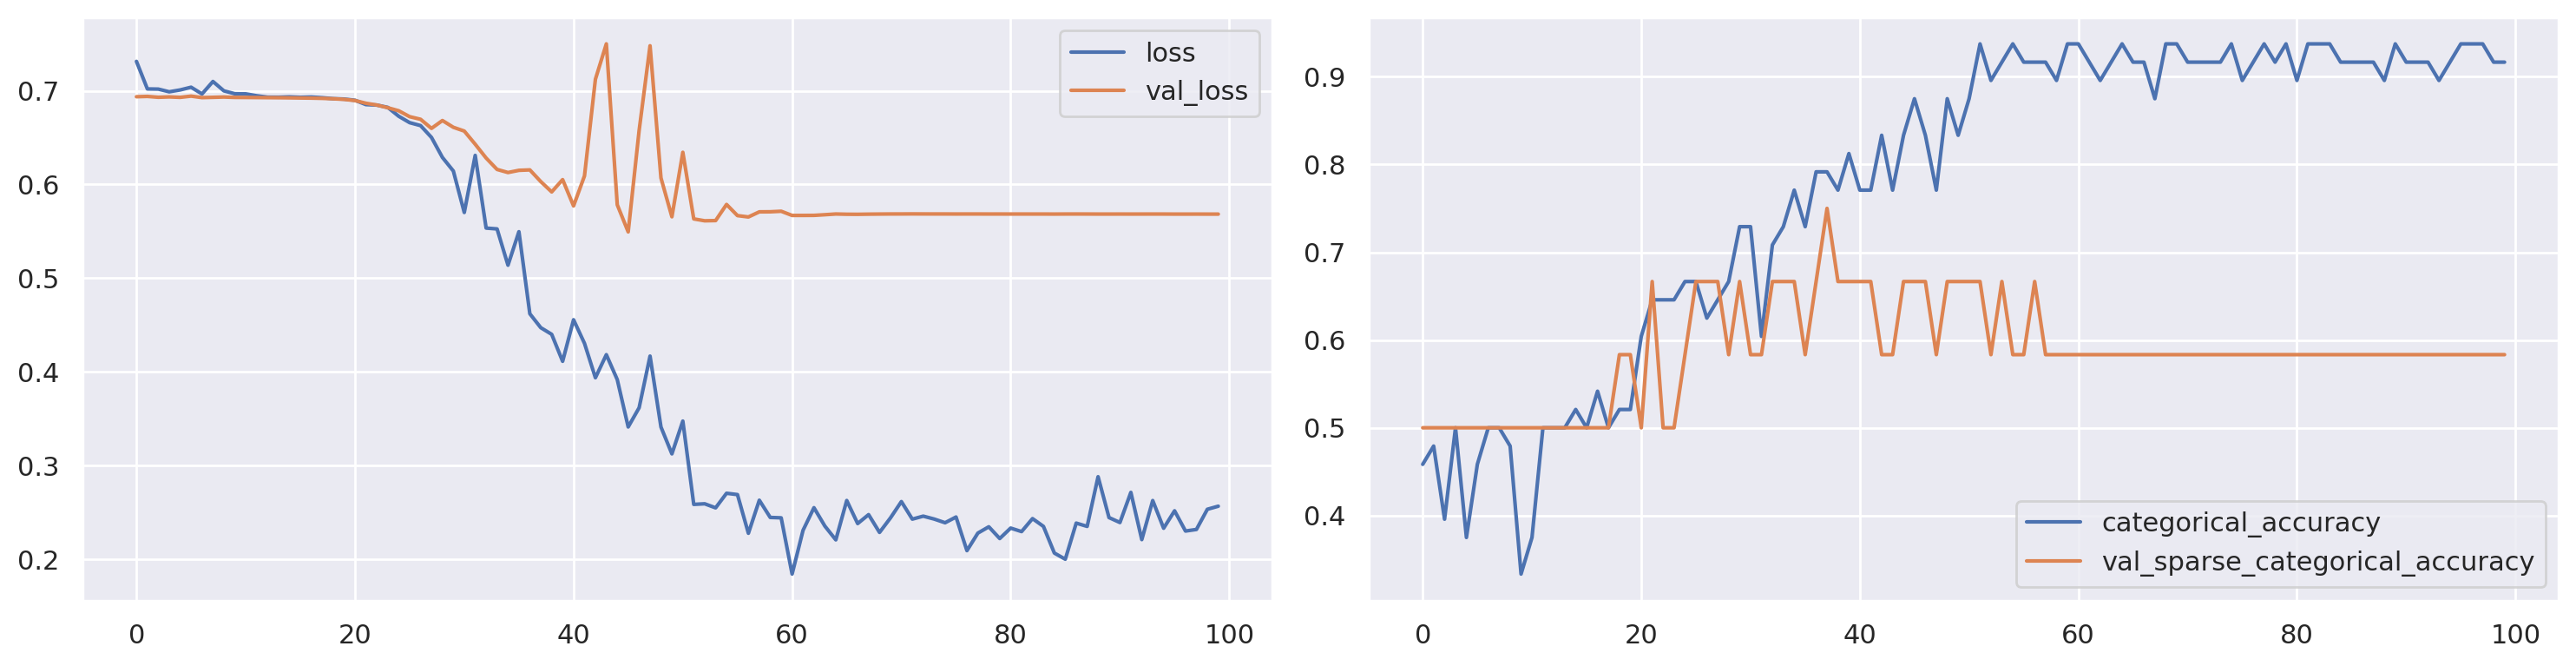

In [19]:
plot(model)

# Lets add more dropout to fight with overfitting

In [20]:
keras.backend.set_image_data_format('channels_first')
class CNN_LTC():

    def init(self):
        self.image_height = 240
        self.image_width = 240
        self.channels = 3
        self.num_classes = 2
        self.frames_to_sample = 31
        self.batch_size = 1
        self.num_epochs = 100
        self.X_train = []
        self.y_train = []
        self.x_test = []
        self.y_test = []
        self.resnet_transfer = resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(3, 240, 240))



    def create_data(self):
        # load train high
        print('train_high')
        dir_path = os.getcwd()
        dir_path += "/train/high"
        for pat in os.listdir(dir_path):
            filename = os.fsdecode(pat)
            for data in os.listdir(str(dir_path + '/'  + str(filename))):
                if "Flair" in data:
                    for file in os.listdir(str(dir_path) + '/'  + str(filename) + '/' + str(data)):
                        if 'mha' in file:
                            print(file)
                            img = list(ITK.GetArrayFromImage(ITK.ReadImage(str(dir_path) + '/'  + str(filename) + '/' + str(data) + '/' + file)))
                            self.X_train.append(np.array([np.array([np.zeros((240, 240)), x / float(255), np.zeros((240, 240))]) for i, x in enumerate(img) if i % 5 == 0 and i > 30 and i < 110]))
                            self.y_train.append([1])
        # load train low
        print('train_low')
        dir_path = os.getcwd()
        dir_path += "/train/low"
        for pat in os.listdir(dir_path):
            filename = os.fsdecode(pat)
            for data in os.listdir(str(dir_path + '/'  + str(filename))):
                if "Flair" in data:
                    for file in os.listdir(str(dir_path) + '/'  + str(filename) + '/' + str(data)):
                        if 'mha' in file:
                            print(file)
                            img = list(ITK.GetArrayFromImage(ITK.ReadImage(str(dir_path) + '/'  + str(filename) + '/' + str(data) + '/' + file)))
                            self.X_train.append(np.array([np.array([np.zeros((240, 240)), x / float(255), np.zeros((240, 240))]) for i, x in enumerate(img) if i % 5 == 0 and i > 30 and i < 110]))
                            self.y_train.append([0])
        # load test high
        print('test_high')
        dir_path = os.getcwd()
        dir_path += "/test/high"
        for pat in os.listdir(dir_path):
            filename = os.fsdecode(pat)
            for data in os.listdir(str(dir_path + '/'  + str(filename))):
                if "Flair" in data:
                    for file in os.listdir(str(dir_path) + '/'  + str(filename) + '/' + str(data)):
                        if 'mha' in file:
                            print(file)
                            img = list(ITK.GetArrayFromImage(ITK.ReadImage(str(dir_path) + '/'  + str(filename) + '/' + str(data) + '/' + file)))
                            self.x_test.append(np.array([np.array([np.zeros((240, 240)), x / float(255), np.zeros((240, 240))]) for i, x in enumerate(img) if i % 5 == 0 and i > 30 and i < 110]))
                            self.y_test.append([1])
        # load test hlow
        print('test_low')
        dir_path = os.getcwd()
        dir_path += "/test/low"
        for pat in os.listdir(dir_path):
            filename = os.fsdecode(pat)
            for data in os.listdir(str(dir_path + '/'  + str(filename))):
                if "Flair" in data:
                    for file in os.listdir(str(dir_path) + '/'  + str(filename) + '/' + str(data)):
                        if 'mha' in file:
                            print(file)
                            img = list(ITK.GetArrayFromImage(ITK.ReadImage(str(dir_path) + '/'  + str(filename) + '/' + str(data) + '/' + file)))
                            self.x_test.append(np.array([np.array([np.zeros((240, 240)), x / float(255), np.zeros((240, 240))]) for i, x in enumerate(img) if i % 5 == 0 and i > 30 and i < 110]))
                            self.y_test.append([0])
        print(len(self.X_train), len(self.y_train), len(self.x_test), len(self.y_test))
        # shuffle
        train = list(zip(self.X_train, self.y_train))
        rn.shuffle(train)
        self.X_train, self.y_train = zip(*train)
        self.X_train = np.array(self.X_train)
        self.y_train = np.array(self.y_train)

        test = list(zip(self.x_test, self.y_test))
        rn.shuffle(test)
        self.x_test, self.y_test = zip(*test)
        self.x_test = np.array(self.x_test)
        self.y_test = np.array(self.y_test)
        print(len(self.X_train), len(self.y_train), len(self.x_test), len(self.y_test))
        print(self.X_train[0].shape)
        return


    def train_model(self, model):

        #checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=5, min_lr=0.000001)
        #earlystop = EarlyStopping(monitor="val_loss", min_delta=0,patience=50,verbose=1)
        self.callbacks_list = [LR]

        history=model.fit(self.X_train, self.y_train, batch_size = self.batch_size, epochs=self.num_epochs, verbose="auto",
                                callbacks=self.callbacks_list, validation_data = (self.x_test, self.y_test))
        return history


    def define_model(self, ncp_neurons=21,dense_neurons=32,dropout=0.15):

        self.wiring = AutoNCP(ncp_neurons,self.num_classes)

        model = Sequential()

        model.add(TimeDistributed(self.resnet_transfer,input_shape=(15,self.channels,240,240)))
        for layer in model.layers: layer.trainable = False
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(Dropout(dropout))


        model.add(TimeDistributed(Flatten()))

        model.add(Dropout(dropout))
        model.add(LTC(self.wiring, return_sequences=False))
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes, activation='softmax'))

        optimiser = optimizers.AdamW(learning_rate=0.01, weight_decay=0.0001)
        model.compile(optimizer=optimiser, loss=keras.losses.SparseCategoricalCrossentropy(), metrics=[keras.metrics.SparseCategoricalAccuracy()])
        return model

In [23]:
cnn_ltc = CNN_LTC()
cnn_ltc.init()
cnn_ltc.create_data()
cnn_ltc_model = cnn_ltc.define_model(ncp_neurons=16,dense_neurons=32,dropout=0.1)
cnn_ltc_model.summary()

train_high
VSD.Brain.XX.O.MR_Flair.35533.mha
VSD.Brain.XX.O.MR_Flair.40827.mha
VSD.Brain.XX.O.MR_Flair.35537.mha
VSD.Brain.XX.O.MR_Flair.35541.mha
VSD.Brain.XX.O.MR_Flair.35545.mha
VSD.Brain.XX.O.MR_Flair.35549.mha
VSD.Brain.XX.O.MR_Flair.35553.mha
VSD.Brain.XX.O.MR_Flair.35557.mha
VSD.Brain.XX.O.MR_Flair.35561.mha
VSD.Brain.XX.O.MR_Flair.35565.mha
VSD.Brain.XX.O.MR_Flair.35573.mha
VSD.Brain.XX.O.MR_Flair.35577.mha
VSD.Brain.XX.O.MR_Flair.35591.mha
VSD.Brain.XX.O.MR_Flair.35595.mha
VSD.Brain.XX.O.MR_Flair.35599.mha
VSD.Brain.XX.O.MR_Flair.35603.mha
VSD.Brain.XX.O.MR_Flair.40859.mha
VSD.Brain.XX.O.MR_Flair.35607.mha
VSD.Brain.XX.O.MR_Flair.40863.mha
VSD.Brain.XX.O.MR_Flair.35611.mha
VSD.Brain.XX.O.MR_Flair.35615.mha
VSD.Brain.XX.O.MR_Flair.40871.mha
VSD.Brain.XX.O.MR_Flair.35619.mha
VSD.Brain.XX.O.MR_Flair.35623.mha
train_low
VSD.Brain.XX.O.MR_Flair.35529.mha
VSD.Brain.XX.O.MR_Flair.40819.mha
VSD.Brain.XX.O.MR_Flair.40823.mha
VSD.Brain.XX.O.MR_Flair.40831.mha
VSD.Brain.XX.O.MR_Flair.355

In [24]:
with tf.device('/device:GPU:0'):
    model = cnn_ltc.train_model(cnn_ltc_model)

Epoch 1/100
48/48 [==============================] - 21s 163ms/step - loss: 0.7193 - sparse_categorical_accuracy: 0.4375 - val_loss: 0.6931 - val_sparse_categorical_accuracy: 0.5000 - lr: 0.0100
Epoch 2/100
48/48 [==============================] - 6s 119ms/step - loss: 0.7022 - sparse_categorical_accuracy: 0.4167 - val_loss: 0.6924 - val_sparse_categorical_accuracy: 0.5000 - lr: 0.0100
Epoch 3/100
48/48 [==============================] - 5s 100ms/step - loss: 0.7040 - sparse_categorical_accuracy: 0.5000 - val_loss: 0.6920 - val_sparse_categorical_accuracy: 0.5000 - lr: 0.0100
Epoch 4/100
48/48 [==============================] - 6s 129ms/step - loss: 0.7028 - sparse_categorical_accuracy: 0.4583 - val_loss: 0.6921 - val_sparse_categorical_accuracy: 0.5000 - lr: 0.0100
Epoch 5/100
48/48 [==============================] - 5s 103ms/step - loss: 0.6994 - sparse_categorical_accuracy: 0.3333 - val_loss: 0.6927 - val_sparse_categorical_accuracy: 0.5000 - lr: 0.0100
Epoch 6/100
48/48 [==========

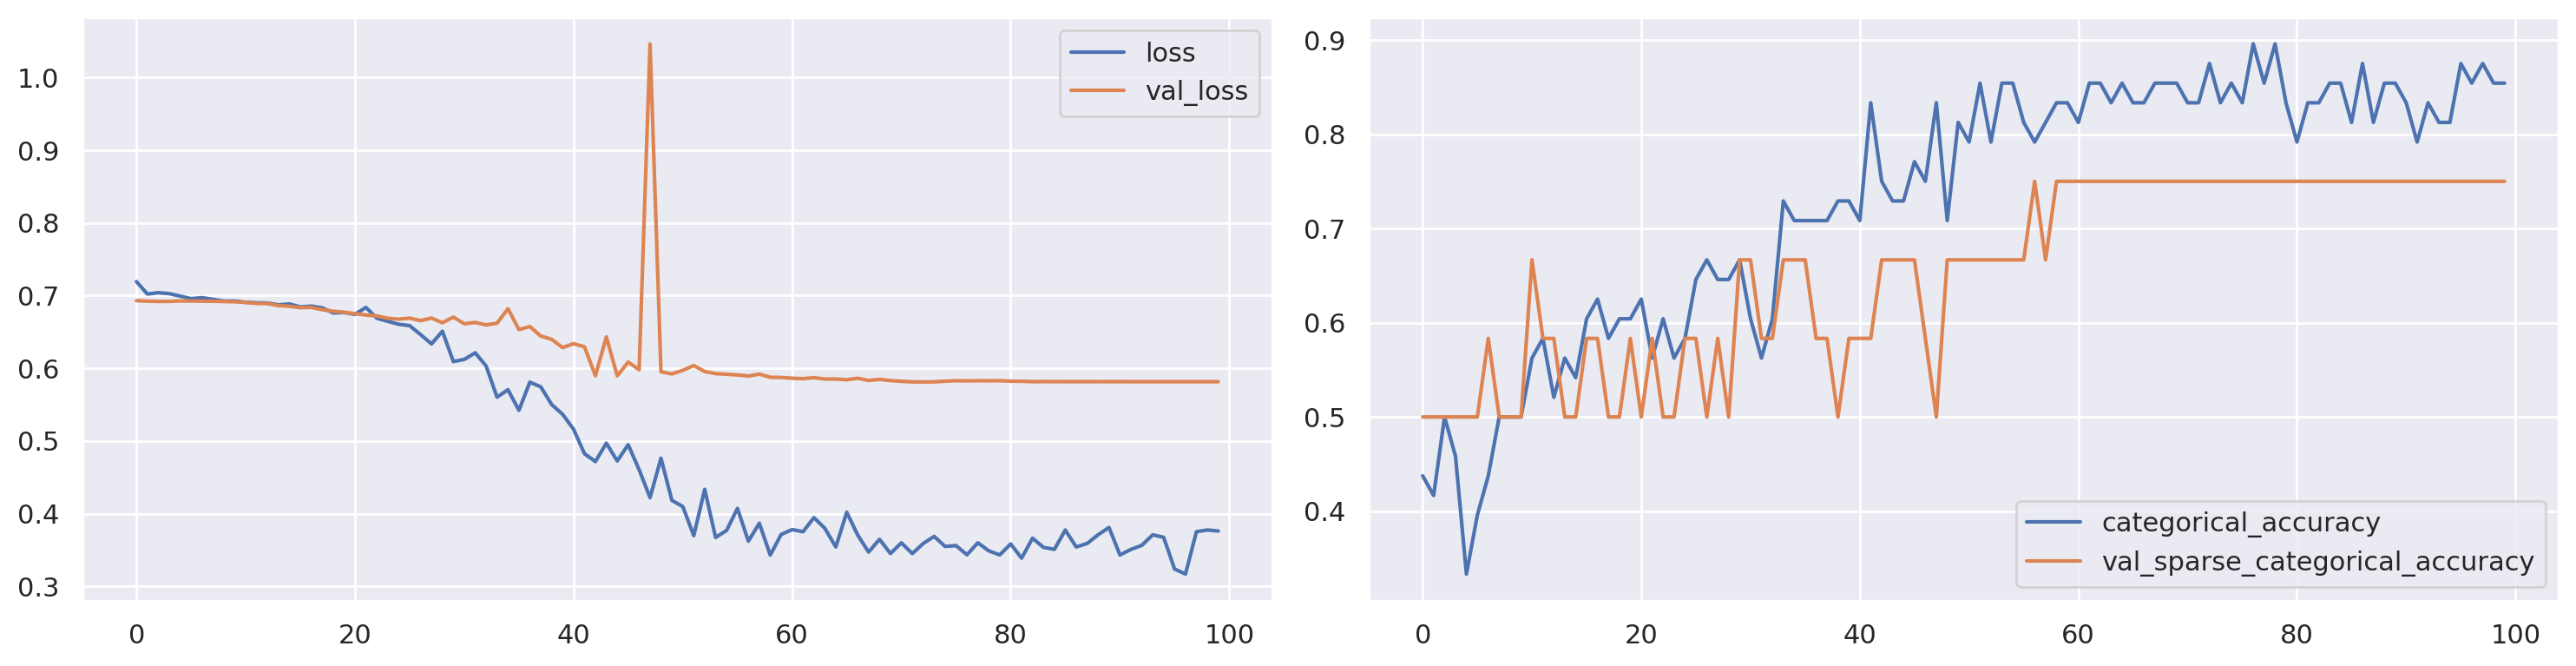

In [25]:
plot(model)

# Good result!